# Working with trajectory data in python

This notebook shows some examples of loading and working with anTraX results in python. The notebook can be downloaded from https://github.com/Social-Evolution-and-Behavior/anTraX/blob/master/docs/analysis_nb.ipynb. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import antrax as ax
from antrax import *
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
idx = pd.IndexSlice

### Load data from a tracked experiment

We will use data from dataset J16. Replace the path to the correct path on your system. By default, data from all IDs ('ants') and all movies will be loaded, but it can be changed using the arguments.

In [7]:
expdir = '/Users/asaf/Code/anTraX-data/JS16'
ex = axExperiment(expdir, session='antrax_demo')
ad = axAntData(ex)

The data is loaded into the antdata object, and is stored in the pandas table antdata.data. By default, the values of the xy coordinates, the orientation angle, and the assignment type are loaded:

In [8]:
ad.data.head()

ant            BB                               BG                         \
feature         x         y  or ass_type         x         y  or ass_type   
frame                                                                       
1        0.039118  0.064093 NaN      4.0  0.040697  0.003249 NaN      4.0   
2        0.039104  0.064093 NaN      4.0  0.040686  0.003249 NaN      4.0   
3        0.039111  0.064087 NaN      4.0  0.040694  0.003245 NaN      4.0   
4        0.039107  0.064080 NaN      4.0  0.040683  0.003244 NaN      4.0   
5        0.039098  0.064067 NaN      4.0  0.040691  0.003250 NaN      4.0   

ant            BO            ...        PO                               PP  \
feature         x         y  ...         x         y  or ass_type         x   
frame                        ...                                              
1        0.039118  0.064093  ...  0.039118  0.064093 NaN      4.0  0.039118   
2        0.039104  0.064093  ...  0.039104  0.064093 NaN      4.0  0.039104   
3        0.039111  0.064087  ...  0.039111  0.064087 NaN      4.0  0.039111   
4        0.039107  0.064080  ...  0.039107  0.064080 NaN      4.0  0.039107   
5        0.039098  0.064067  ...  0.039098  0.064067 NaN      4.0  0.039098   

ant                             m mf  
feature         y  or ass_type        
frame                                 
1        0.064093 NaN      4.0  1  1  
2        0.064093 NaN      4.0  1  2  
3        0.064087 NaN      4.0  1  3  
4        0.064080 NaN      4.0  1  4  
5        0.064067 NaN      4.0  1  5  

[5 rows x 66 columns]

The 'ass_type' column indicates the type of assigment: 

(1) single-animal tracklet assigned by the blob classifier 

(2) single-animal tracklet assigned by the propagation algorithm

(3) multi-animal tracklet assigned by the propagation algorithm

(4) soft assigment (tracklet that is the only possible one for that ID, but was not assigned by the propagation)

(5) interpolation of coordinates, not corresponding to an actual blob

(NaN) no coordinates

See the anTraX publication for more details.

### Plot the trajectories of two ants, with the background image as background

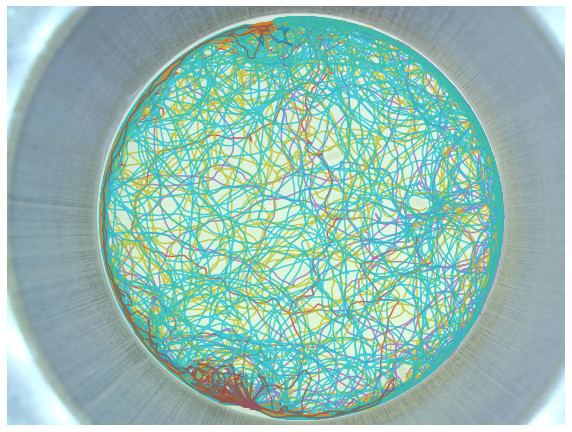

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10 ,10))

# load the background image
bg = ex.get_bg()

# get the scale parameter to convert real world units to pixels
scale = ex.prmtrs['geometry_rscale']

# show the image
ax.imshow(bg)

# plot trajectories on image
for ant in ex.antlist:
    x = ad.data.loc[:, idx[ant, 'x']]/scale
    y = ad.data.loc[:, idx[ant, 'y']]/scale
    ax.plot(x, y, alpha=0.75)

# hide axis
ax.axis('off');


### Plot untagged trajectories

In [33]:
td = axTrackletData(ex)
print(td.trdata.head())

   tracklet  frame    orient      area  nants      majax         x         y  \
0         1      1  2.028523  0.000003    NaN  36.225571  0.015290  0.033978   
1         1      2  2.009901  0.000003    NaN  36.292057  0.015270  0.034029   
2         1      3  1.916012  0.000002    NaN  35.344376  0.015302  0.034018   
3         1      4  1.798527  0.000002    NaN  34.647282  0.015306  0.034032   
4         1      5  1.697938  0.000002    NaN  34.339222  0.015300  0.034049   

   m  
0  1  
1  1  
2  1  
3  1  
4  1  


In [32]:
td.trdata['area'].mean()

5.9972056862024295e-06

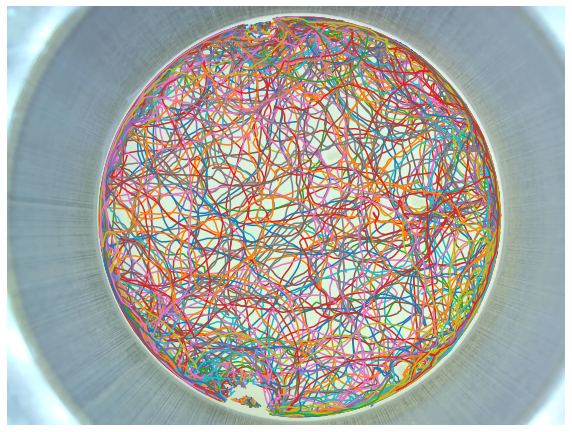

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10 ,10))

# load the background image
bg = ex.get_bg()

# get the scale parameter to convert real world units to pixels
scale = ex.prmtrs['geometry_rscale']

# show the image
ax.imshow(bg)

for tracklet, tracklet_data in td.trdata.groupby(['tracklet','m']):
    ax.plot(tracklet_data['x']/scale, tracklet_data['y']/scale)

# hide axis
ax.axis('off');

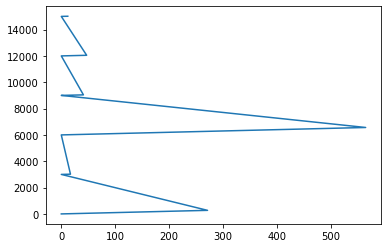

In [25]:
tracklet1 = td.trdata[td.trdata['tracklet']==1]
plt.plot(tracklet1['frame'])

### Plot the trajectories of all ants  

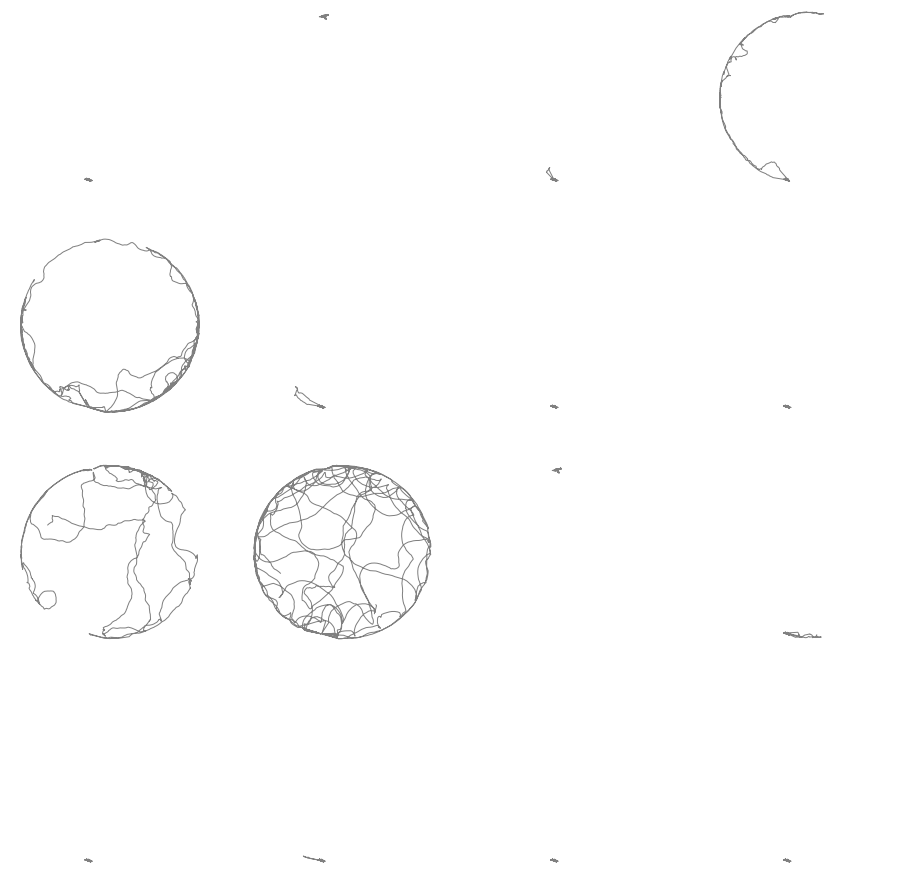

In [12]:
# reload, this time with all ants
ad = axAntData(ex, movlist=[1])

# now plot (note the use the negative of y to have 
# the same axis orientation as the images)
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.flatten()

for i, ant in enumerate(ex.antlist):
    axs[i].plot(ad.data.loc[:, idx[ant, 'x']], -ad.data.loc[:, idx[ant,'y']], 
                color='grey', linewidth=1)
    axs[i].set_xlim((0.01, 0.08))
    axs[i].set_ylim((-0.07, 0))
    axs[i].axis('off')

### Calculating some measures

Define the nest location as the median location of all ants. This is possible because in this experiment, the majority of the ants are in the nest for the majority of the time. To account for periods when many ants leave the nest for a short time, we will use median smoothing:

In [7]:
# calculating proxi for nest location
ad.data[('nest', 'x')] = \
        ad.data.loc[:, idx[:, 'x']].interpolate(limit_area='inside').median(axis=1)
ad.data[('nest', 'y')] = \
        ad.data.loc[:, idx[:, 'y']].interpolate(limit_area='inside').median(axis=1)

# temporal smoothing for consistency
window = 3001 # 5 minute in frames 
ad.data[('nest', 'x')] = \
        ad.data[('nest', 'x')].rolling(window, center=True).median()
ad.data[('nest', 'y')] = \
        ad.data[('nest', 'y')].rolling(window, center=True).median()

# for each ant, add a column which is True if the ant is 
# outside the nest (distance above threshold)
thresh = 0.01 # in meters
for ant in ad.antlist:
    dx = ad.data[ant]['x'] - ad.data['nest']['x']
    dy = ad.data[ant]['y'] - ad.data['nest']['y']
    ad.data[(ant, 'dnest')] = np.sqrt(dx**2 + dy**2)
    ad.data[(ant, 'outside')] = ad.data[(ant, 'dnest')] > thresh       


 
Plot the nest trajectory on top of one frame from the experiment

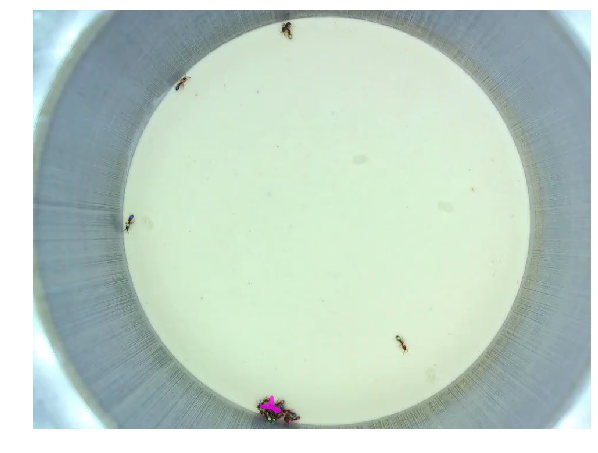

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10 ,10))

# load the first frame in the movie
frame = ex.get_frame(1)

# get the scale parameter to convert real world units to pixels
scale = ex.prmtrs['geometry_rscale']

# show the image
ax.imshow(frame)

# plot nest trajectory on image
x = ad.data.loc[:,idx['nest','x']]/scale
y = ad.data.loc[:,idx['nest','y']]/scale
ax.plot(x, y, alpha=0.75, color='magenta', linewidth=3)

# hide axis
ax.axis('off');

Add velocity column to data table

In [9]:
for ant in ad.antlist:
    dx = ad.data[ant]['x'].diff()
    dy = ad.data[ant]['y'].diff()
    ad.data[(ant, 'v')] = np.sqrt(dx**2 + dy**2)


Plot velocity histogram when outside of the nest

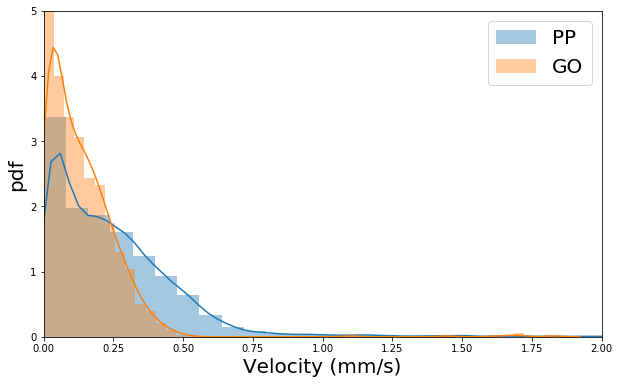

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

for ant in ['PP', 'GO']:
    v = ad.data[ant]['v']
    v = v[ad.data[ant]['outside']]
    v = v[~np.isnan(v)]
    sns.distplot(1000*v, label=ant)

ax.set_xlim((0, 2))
ax.set_ylim((0, 5));
ax.set_xlabel('Velocity (mm/s)', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
ax.legend(fontsize=20);

### Loading JAABA scores

This is an example of loading tracks together with JAABA classifications (in case JAABA analysis was done using the anTraX interface). We will use the A36 dataset, which comes with some JAABA classifications (see anTraX publication figure 5).

In [11]:
expdir = '/Users/asaf/Box Sync/anTraX/datasets/A36'
ex = axExperiment(expdir, session='antrax')
ant = 'YY'
ad = axAntData(ex, movlist=[1], antlist=[ant])
ad.set_jaaba(behaviors=['WalkWithLarva'])
ad.data.head()

ant            YY                                         
feature        or scores_WalkWithLarva         x         y
frame                                                     
1             NaN            -0.067551  0.104412  0.046353
2             NaN            -0.644878  0.104372  0.046459
3        0.984315             2.967741  0.103487  0.045808
4        1.083810             1.790937  0.103467  0.045851
5        1.248774             0.771301  0.103476  0.046042

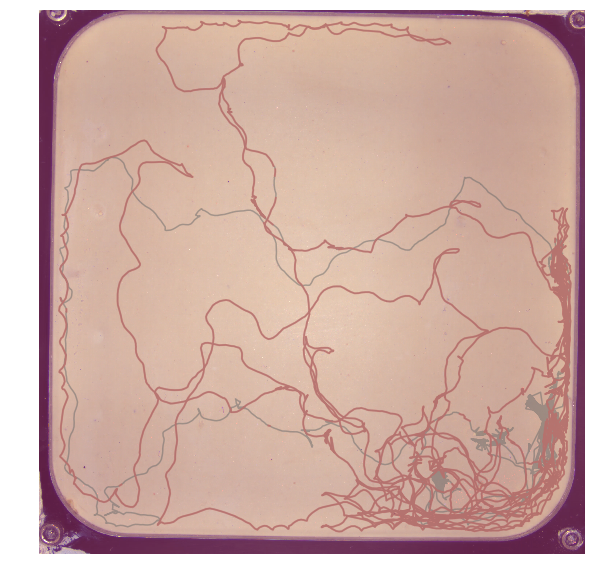

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10 ,10))


# load the background image
bg = ex.get_bg()

# get the scale parameter to convert real world units to pixels
scale = ex.prmtrs['geometry_rscale']

# show the image
ax.imshow(bg)

# plot trajectories on image
x = ad.data.loc[:, idx['YY', 'x']]/scale
y = ad.data.loc[:, idx['YY', 'y']]/scale
ax.plot(x, y, alpha=0.5, color='dimgrey')

# plot the part of the trajectory classified as WalkWithLarva
ix = ad.data.loc[:, idx['YY', 'scores_WalkWithLarva']] <= 0
x[ix] = np.nan
y[ix] = np.nan

ax.plot(x, y, alpha=0.5, color='indianred', linewidth=2)

# hide axis
ax.axis('off');


### Loading DeepLabCut tracking results

This is an example of loading tracks together with DeepLabCut pose tracking results (see the corresponding section). We will use the A36 dataset, which comes with some DLC tracking results (see anTraX publication figure 5). Loading DLC results might take a bit of time.

In [13]:
expdir = '/Users/asaf/Box Sync/anTraX/datasets/A36'
ant = 'BG'
ex = axExperiment(expdir, session='antrax')
ad = axAntData(ex, movlist=[1], antlist=[ant])
ad.set_dlc(dlcproject='ant_walk')
ad.data.head()

ant                  BG                                              \
feature Head_likelihood     Head_x     Head_y L_ant_root_likelihood   
frame                                                                 
1                   1.0  57.019531  86.535126                   1.0   
2                   1.0  59.313236  86.148636                   1.0   
3                   1.0  57.335224  86.026962                   1.0   
4                   1.0  57.449387  86.664284                   1.0   
5                   1.0  58.715736  86.012360                   1.0   

ant                                                                 \
feature L_ant_root_x L_ant_root_y L_ant_tip_likelihood L_ant_tip_x   
frame                                                                
1          59.921867    85.271690                  1.0   70.675316   
2          62.381512    85.355553                  1.0   73.407570   
3          60.696117    85.687279                  1.0   70.976707   
4          60.008621    85.545258                  1.0   70.923218   
5          61.875813    86.263512                  1.0   72.561050   

ant                                        ...                        \
feature L_ant_tip_y L_fore_leg_likelihood  ...     Tail_x     Tail_y   
frame                                      ...                         
1         97.965607              0.100535  ...  60.399506  23.330620   
2         94.271118              1.000000  ...  59.037693  22.211269   
3         99.199463              0.999700  ...  58.905304  22.702879   
4         98.761978              1.000000  ...  57.982689  24.236153   
5         94.803192              0.998647  ...  59.167442  23.670507   

ant                                                                        \
feature ThxAbd_likelihood   ThxAbd_x   ThxAbd_y    bbx0    bby0        or   
frame                                                                       
1                     1.0  55.955524  46.047829  1015.0  1821.0  2.195363   
2                     1.0  58.473812  47.334602  1007.0  1831.0  2.208462   
3                     1.0  58.123581  46.089836   995.0  1843.0  2.308996   
4                     1.0  56.893967  45.873936   988.0  1850.0  2.385155   
5                     1.0  56.356113  45.579929   985.0  1856.0  2.264540   

ant                          
feature         x         y  
frame                        
1        0.038170  0.067304  
2        0.037908  0.067667  
3        0.037567  0.068016  
4        0.037339  0.068228  
5        0.037132  0.068539  

[5 rows x 47 columns]

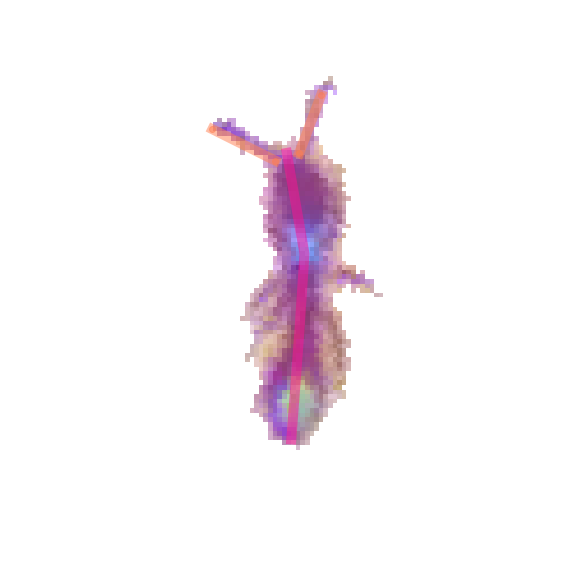

In [14]:
# DLC was run only on frames inw which the ant was assigned to single-ant tracklets
# all the rest were asssigned NaN, so we need first to get a list of these frames
dlc_frames = ad.data.index[~np.isnan(ad.data[ant]['Head_x'])]

# now lets just pick one
f = dlc_frames[100]

# get the ant image 
# note that this will work only for frames in which the tracklet is single ant
image = ad.get_image(ant, f)

# get the correct row
row = ad.data.loc[f,idx[ant,:]].droplevel(axis=0,level=0)

fig, ax = plt.subplots(1, 1, figsize=(10 ,10))

# show image
plt.imshow(image, origin='lower')

# plot body axis
ax.plot([row['Head_x'],row['Neck_x'],row['ThxAbd_x'],row['Tail_x']],
        [row['Head_y'],row['Neck_y'],row['ThxAbd_y'],row['Tail_y']], 
        '-', linewidth=10, alpha=0.5, color='deeppink')

# plot antennae
ax.plot([row['L_ant_root_x'],row['L_ant_tip_x']],
        [row['L_ant_root_y'],row['L_ant_tip_y']],
        '-o', linewidth=10, alpha=0.5, color='coral')

ax.plot([row['R_ant_root_x'],row['R_ant_tip_x']],
        [row['R_ant_root_y'],row['R_ant_tip_y']],
        '-o', linewidth=10, alpha=0.5, color='coral')        

ax.axis('off');
